## LB 0.607456
catboost比較高 用xgb下降

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import (KFold,StratifiedKFold,cross_validate,train_test_split)
import lightgbm as lgb
# from sklearn import svm
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
import xgboost as xgb

from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix,f1_score
import time
import random
import os
import sys


path_raw_data = os.getcwd() + '/raw_data'
# path_processed_data = '../Data/processed'
# path_prediction_data = '../Data/predictions'
col_target = 'fraud_ind'
col_id = 'txkey'
seed = 8787
n_fold = 10

In [34]:
print(path_raw_data)

/Users/leechenghsuan/Downloads/fwd/raw_data


In [38]:
train = pd.read_csv(r'//Users//leechenghsuan//raw_data//train.csv')
train.head()

,acqic,bacno,cano,conam,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,...,iterm,locdt,loctm,mcc,mchno,ovrlt,scity,stocn,stscd,txkey
0,6881,113261,38038,513.80,5,0,N,0,N,N,...,0,33,172652.0,457,59333,N,0,102,0,516056
1,0,134508,45725,465.62,5,0,N,2,N,N,...,0,9,105114.0,451,0,N,5817,102,0,4376
2,6881,15408,188328,513.80,5,0,N,0,N,N,...,0,6,152458.0,457,59333,N,0,102,0,483434
3,6716,157159,29967,1016.11,5,62,N,5,N,N,...,0,5,172946.0,247,50436,N,3281,102,0,1407164
4,5975,105985,81305,713.66,5,62,N,4,N,N,...,0,6,182129.0,263,93775,N,5817,102,0,1051004


# 1. loading data

In [40]:
time_start = time.time()
train = pd.read_csv(os.path.join(path_raw_data, 'train.csv'))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42) 
#df_test = pd.read_csv(os.path.join(path_raw_data, 'test.csv'))
time_end = time.time()
print('spent: {}'.format(time_end-time_start))

FileNotFoundError: [Errno 2] File b'/Users/leechenghsuan/Downloads/fwd/raw_data/train.csv' does not exist: b'/Users/leechenghsuan/Downloads/fwd/raw_data/train.csv'

In [3]:
df_train_id = df_train[col_id]
df_test_id = df_test[col_id]
target = df_train[col_target]

df_train.drop([col_id], axis = 1, inplace = True)
df_test.drop([col_id], axis = 1, inplace = True)


### drop duplicates

In [4]:
df_train = df_train.drop_duplicates(keep = 'first')
ntrain = df_train.shape[0]

In [102]:
df_full = pd.concat((df_train,df_test),sort = False).reset_index(drop = True)
print(df_train.shape, df_test.shape, df_full.shape)

(1516988, 22) (421665, 21) (1938653, 22)


In [103]:
pd.options.display.max_columns=40
df_full.head()

,acqic,bacno,cano,conam,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,fraud_ind,hcefg,insfg,iterm,locdt,loctm,mcc,mchno,ovrlt,scity,stocn,stscd
0,6881,113261,38038,513.80,5,0,N,0,N,N,0.0,5,N,0,33,172652.0,457,59333,N,0,102,0
1,0,134508,45725,465.62,5,0,N,2,N,N,0.0,0,N,0,9,105114.0,451,0,N,5817,102,0
2,6881,15408,188328,513.80,5,0,N,0,N,N,0.0,5,N,0,6,152458.0,457,59333,N,0,102,0
3,6716,157159,29967,1016.11,5,62,N,5,N,N,0.0,5,N,0,5,172946.0,247,50436,N,3281,102,0
4,5975,105985,81305,713.66,5,62,N,4,N,N,0.0,5,N,0,6,182129.0,263,93775,N,5817,102,0


# 2. EDA

In [104]:
# need to drop these columns when training model
for col in df_test.columns:
    q = df_test[col].isin(df_train[col]).sum() / df_test.shape[0]
    if q < 0.9:
        print('test set and train set',col,'interset %.2f' %q)

test set and train set bacno interset 0.05
test set and train set cano interset 0.05
test set and train set locdt interset 0.00


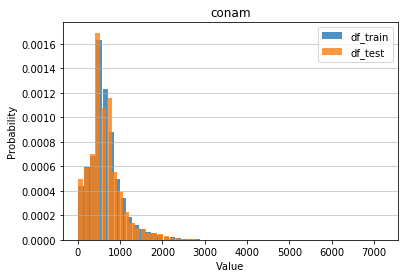

In [105]:
col_eda = 'conam'
plt.hist(df_train[col_eda],bins=50,label='df_train',alpha=0.8,rwidth=0.9,density=True)
plt.hist(df_test[col_eda],bins=50,label='df_test',alpha=0.8,rwidth=0.9,density=True)
plt.legend(loc='upper right')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Probability')
plt.title(col_eda)
plt.show()

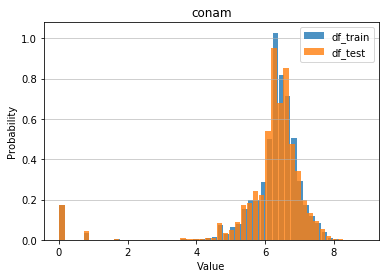

In [106]:
col_eda = 'conam'
plt.hist(np.log1p(df_train[col_eda]),bins=50,label='df_train',alpha=0.8,rwidth=0.9,density=True)
plt.hist(np.log1p(df_test[col_eda]),bins=50,label='df_test',alpha=0.8,rwidth=0.9,density=True)
plt.legend(loc='upper right')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Probability')
plt.title(col_eda)
plt.show()

In [107]:
# 先醬

# 3. preprocessing

In [108]:
# generate time feature ( format hhmmss)
df_full['loctm_time'] = df_full['loctm'].apply(lambda x: '0'*(6 - len(str(int(x)))) + str(int(x)))
df_full['loctm_time'] = df_full['loctm_time'].apply(lambda x: x[:2] + ':' + x[2:4] + ':' + x[4:])
df_full['loctm_time'] = pd.to_datetime(df_full['loctm_time'], format='%H:%M:%S')

In [109]:
df_full.insert(3,'time_hour', df_full['loctm_time'].dt.hour)
df_full.insert(3,'time_min', df_full['loctm_time'].dt.minute)
df_full.insert(3,'time_sec', df_full['loctm_time'].dt.second)

In [110]:
# temporarily do need to 'time' feature
# df_full.insert(3,'time',df_full['locdt']*86400+ df_full['time_hour']*3600 + df_full['time_min']*60 + df_full['time_sec'])

In [111]:
# # log transform--conam
# df_full['conam'] = np.log1p(df_full['conam'])

In [112]:
# #先簡單將 Na 補 mode值
# train.loc[train.flbmk.isnull(),'flbmk'] = train.flbmk.value_counts().index[0]
# train.loc[train.flg_3dsmk.isnull(),'flg_3dsmk'] = train.flg_3dsmk.value_counts().index[0]

# test.loc[test.flbmk.isnull(),'flbmk'] = test.flbmk.value_counts().index[0]
# test.loc[test.flg_3dsmk.isnull(),'flg_3dsmk'] = test.flg_3dsmk.value_counts().index[0]

# # Y - > 1
# for col in train.columns[train.dtypes=='object'].tolist():
#     train[col] = np.where(train[col]=='Y',1,0)

# for col in test.columns[test.dtypes=='object'].tolist():
#     test[col] = np.where(test[col]=='Y',1,0)

# 4. Feature Engineering

## 4.1 generate columns using conam

## 4.1.1 Groupby bacno, locdt, loctm

In [113]:
# 大部分的人在同一個'locdt','loctm'下只會有一筆紀錄，所以取statistics的效益不大?
df_full.groupby(['bacno','locdt','loctm']).size().reset_index().\
rename(columns={0:'fre'}).sort_values('fre',ascending=False).fre.value_counts()

1    1908769
2      10724
3       1758
4        500
5        121
6         55
7         22
8          8
9          1
Name: fre, dtype: int64

In [114]:
df_full_groupby = df_full.groupby(['bacno','locdt','loctm']).agg({'conam':['sum','count']})
df_full_groupby.columns = df_full_groupby.columns.droplevel()
df_full_groupby.reset_index(inplace = True)
print('dim:',df_full_groupby.shape)
df_full_groupby.head()

dim: (1921958, 5)


,bacno,locdt,loctm,sum,count
0,0,102,100045.0,929.46,1
1,1,3,200000.0,934.49,1
2,1,4,221428.0,939.19,1
3,1,25,212635.0,1267.47,1
4,1,30,200947.0,1017.37,1


In [115]:
cumsum = df_full_groupby.groupby(['bacno'])['sum'].cumsum()
cumcnt = df_full_groupby.groupby(['bacno']).cumcount()
cummax = df_full_groupby.groupby(['bacno'])['sum'].cummax()

In [116]:
df_full_groupby['cumsum'] = cumsum
# 不包含自己的累加sum
df_full_groupby['cumsum'] = df_full_groupby['cumsum'] - df_full_groupby['sum']
df_full_groupby['cummean'] = df_full_groupby['cumsum'] / cumcnt
df_full_groupby['cummax'] = cummax
df_full_groupby['val_diff_of_sum_with_cummax']  = df_full_groupby['sum'] - df_full_groupby['cummax']
df_full_groupby['val_diff_of_sum_with_cummean'] = df_full_groupby['sum'] - df_full_groupby['cummean']

In [117]:
print(df_full_groupby.shape)
df_full_groupby.head()

(1921958, 10)


,bacno,locdt,loctm,sum,count,cumsum,cummean,cummax,val_diff_of_sum_with_cummax,val_diff_of_sum_with_cummean
0,0,102,100045.0,929.46,1,0.00,NaN,929.46,0.0,NaN
1,1,3,200000.0,934.49,1,0.00,NaN,934.49,0.0,NaN
2,1,4,221428.0,939.19,1,934.49,934.49,939.19,0.0,4.70
3,1,25,212635.0,1267.47,1,1873.68,936.84,1267.47,0.0,330.63
4,1,30,200947.0,1017.37,1,3141.15,1047.05,1267.47,-250.1,-29.68


In [118]:
# Merge Data
df_full = df_full.merge(df_full_groupby, on = ['bacno','locdt','loctm'], how = 'left')

## 4.1.2 Groupby bacno, hr from time

In [119]:
df_full_groupby = df_full.groupby(['bacno','time_hour']).agg({'conam':['sum','count']})
df_full_groupby.columns = df_full_groupby.columns.droplevel()
df_full_groupby.reset_index(inplace = True)
print('dim:',df_full_groupby.shape)
df_full_groupby.head()

dim: (907482, 4)


,bacno,time_hour,sum,count
0,0,10,929.46,1
1,1,13,1502.82,2
2,1,14,643.76,1
3,1,15,613.81,1
4,1,19,954.83,1


In [120]:
# 因為前面的值是淺複製 所以被蓋掉了
cumsum = df_full_groupby.groupby(['bacno'])['sum'].cumsum()
cumcnt = df_full_groupby.groupby(['bacno']).cumcount()
cummax = df_full_groupby.groupby(['bacno'])['sum'].cummax()

In [121]:
df_full_groupby['cumsum'] = cumsum
# 不包含自己的累加sum
df_full_groupby['cumsum'] = df_full_groupby['cumsum'] - df_full_groupby['sum']
df_full_groupby['cummean'] = df_full_groupby['cumsum'] / cumcnt
df_full_groupby['cummax'] = cummax
df_full_groupby['val_diff_of_sum_with_cummax']  = df_full_groupby['sum'] - df_full_groupby['cummax']
df_full_groupby['val_diff_of_sum_with_cummean'] = df_full_groupby['sum'] - df_full_groupby['cummean']

In [122]:
col_hr = df_full_groupby.columns.tolist()
for i in range(len(col_hr[2:])):
    col_hr[2+i] = col_hr[2+i] + '_hr'

In [123]:
df_full_groupby.columns = col_hr

In [124]:
df_full_groupby.head()

,bacno,time_hour,sum_hr,count_hr,cumsum_hr,cummean_hr,cummax_hr,val_diff_of_sum_with_cummax_hr,val_diff_of_sum_with_cummean_hr
0,0,10,929.46,1,0.00,NaN,929.46,0.00,NaN
1,1,13,1502.82,2,0.00,NaN,1502.82,0.00,NaN
2,1,14,643.76,1,1502.82,1502.82,1502.82,-859.06,-859.06
3,1,15,613.81,1,2146.58,1073.29,1502.82,-889.01,-459.48
4,1,19,954.83,1,2760.39,920.13,1502.82,-547.99,34.70


In [125]:
# Merge Data
df_full = df_full.merge(df_full_groupby, on = ['bacno','time_hour'], how = 'left')

In [126]:
df_full.head()

,acqic,bacno,cano,time_sec,time_min,time_hour,conam,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,fraud_ind,hcefg,insfg,iterm,locdt,loctm,mcc,mchno,ovrlt,scity,stocn,stscd,loctm_time,sum,count,cumsum,cummean,cummax,val_diff_of_sum_with_cummax,val_diff_of_sum_with_cummean,sum_hr,count_hr,cumsum_hr,cummean_hr,cummax_hr,val_diff_of_sum_with_cummax_hr,val_diff_of_sum_with_cummean_hr
0,6881,113261,38038,52,26,17,513.80,5,0,N,0,N,N,0.0,5,N,0,33,172652.0,457,59333,N,0,102,0,1900-01-01 17:26:52,513.80,1,11914.09,567.337619,1038.68,-524.88,-53.537619,7852.80,12,23296.59,2329.659000,7852.80,0.00,5523.141000
1,0,134508,45725,14,51,10,465.62,5,0,N,2,N,N,0.0,0,N,0,9,105114.0,451,0,N,5817,102,0,1900-01-01 10:51:14,465.62,1,1885.23,628.410000,664.07,-198.45,-162.790000,3259.34,7,1867.71,622.570000,3259.34,0.00,2636.770000
2,6881,15408,188328,58,24,15,513.80,5,0,N,0,N,N,0.0,5,N,0,6,152458.0,457,59333,N,0,102,0,1900-01-01 15:24:58,513.80,1,0.00,NaN,513.80,0.00,NaN,2494.90,4,2783.36,695.840000,2494.90,0.00,1799.060000
3,6716,157159,29967,46,29,17,1016.11,5,62,N,5,N,N,0.0,5,N,0,5,172946.0,247,50436,N,3281,102,0,1900-01-01 17:29:46,1016.11,1,3450.74,1150.246667,1828.20,-812.09,-134.136667,7415.51,8,39299.50,4366.611111,12533.10,-5117.59,3048.898889
4,5975,105985,81305,29,21,18,713.66,5,62,N,4,N,N,0.0,5,N,0,6,182129.0,263,93775,N,5817,102,0,1900-01-01 18:21:29,713.66,1,1892.52,473.130000,713.66,0.00,240.530000,5756.03,9,28040.57,2336.714167,5756.03,0.00,3419.315833


## 4.2 create new categorical features
Sum of ecfg(网络交易标记) with flg_3dsmk(3ds交易标记-线上)  
Sum of ecfg(网络交易标记) with flbmk(磁条交易)

In [30]:
# # Sum of ecfg(网络交易标记) with flg_3dsmk(3ds交易标记-线上)
# df_full['cat_sum_of_ecfg_with_flg_3dsmk'] = df_full['ecfg'] + df_full['flg_3dsmk']

In [31]:
# # Sum of ecfg(网络交易标记) with flbmk(磁条交易)
# df_full['cat_sum_of_flbmk_with_flg_ecfg'] = df_full['flbmk'] + df_full['ecfg']

In [32]:
# df_full['cat_sum_of_ecfg_with_flg_3dsmk'].unique()

array(['NN', 'YN', 'YY', nan], dtype=object)

In [33]:
# df_full['cat_sum_of_flbmk_with_flg_ecfg'].unique()

array(['NN', 'NY', 'YN', nan], dtype=object)

## 4.3 Encoding

### 4.3.1 Frequency Encoding: 
Categorical Feature: ['contp', 'etymd', 'mchno', 'acqic', 'mcc', 'stocn', 'scity', 'stscd', 'csmcu'] 代表該值出現的頻率 by bacno

In [127]:
frequency_encoding_features = ['contp', 'etymd', 'mchno', 'acqic', 'mcc', 'stocn', 'scity', 'stscd', 'csmcu']
for feature in frequency_encoding_features:
    frequency = df_full.groupby(['bacno',feature]).size() / df_full.groupby(['bacno']).size()
    frequency = pd.DataFrame(frequency)
    frequency.reset_index(inplace = True)
    frequency.rename(columns = {0: 'fre_{}'.format(feature)},inplace = True)
    
    df_full = df_full.merge(frequency, on = ['bacno',feature], how ='left')

In [128]:
df_full.loc[df_full['bacno']==3, ['bacno','contp', 'fre_contp','etymd','fre_etymd']]

,bacno,contp,fre_contp,etymd,fre_etymd
83511,3,5,1.0,4,0.222222
84359,3,5,1.0,2,0.555556
599913,3,5,1.0,5,0.222222
811664,3,5,1.0,2,0.555556
983187,3,5,1.0,5,0.222222
1267556,3,5,1.0,2,0.555556
1389000,3,5,1.0,2,0.555556
1390174,3,5,1.0,2,0.555556
1498689,3,5,1.0,4,0.222222


### 4.3.2 Mean encoding 
Categorical Feature: ['contp', 'etymd', 'mchno', 'acqic', 'mcc', 'stocn', 'scity', 'stscd', 'csmcu']   
target:conam

看要不要加 by bacno ???????

thinking: 每個人在某些商店平常都錯什麼消費的均值?

In [129]:
mean_encoding_features = ['contp', 'etymd', 'mchno', 'acqic', 'mcc', 'stocn', 'scity', 'stscd', 'csmcu']

In [130]:
for feature in mean_encoding_features:
    mean_encoder = df_train.groupby([feature])['conam'].mean()
    df_full.loc[:, 'mean_encoding_{}'.format(feature)] = df_full[feature].map(mean_encoder)

### 4.3.3 Onehot encoding

In [131]:
df_full.select_dtypes(include='object').columns

Index(['ecfg', 'flbmk', 'flg_3dsmk', 'insfg', 'ovrlt'], dtype='object')

In [132]:
df_full = pd.get_dummies(df_full)
df_full.head()

,acqic,bacno,cano,time_sec,time_min,time_hour,conam,contp,csmcu,etymd,fraud_ind,hcefg,iterm,locdt,loctm,mcc,mchno,scity,stocn,stscd,...,fre_csmcu,mean_encoding_contp,mean_encoding_etymd,mean_encoding_mchno,mean_encoding_acqic,mean_encoding_mcc,mean_encoding_stocn,mean_encoding_scity,mean_encoding_stscd,mean_encoding_csmcu,ecfg_N,ecfg_Y,flbmk_N,flbmk_Y,flg_3dsmk_N,flg_3dsmk_Y,insfg_N,insfg_Y,ovrlt_N,ovrlt_Y
0,6881,113261,38038,52,26,17,513.80,5,0,0,0.0,5,0,33,172652.0,457,59333,0,102,0,...,0.212500,645.42886,501.943813,515.862559,516.326504,521.168033,674.222795,487.976380,655.016149,484.199395,1,0,1,0,1,0,1,0,1,0
1,0,134508,45725,14,51,10,465.62,5,0,2,0.0,0,0,9,105114.0,451,0,5817,102,0,...,0.391304,645.42886,671.352413,489.841716,438.942944,465.620000,674.222795,681.007724,655.016149,484.199395,1,0,1,0,1,0,1,0,1,0
2,6881,15408,188328,58,24,15,513.80,5,0,0,0.0,5,0,6,152458.0,457,59333,0,102,0,...,0.277778,645.42886,501.943813,515.862559,516.326504,521.168033,674.222795,487.976380,655.016149,484.199395,1,0,1,0,1,0,1,0,1,0
3,6716,157159,29967,46,29,17,1016.11,5,62,5,0.0,5,0,5,172946.0,247,50436,3281,102,0,...,1.000000,645.42886,603.124520,1066.048975,807.167328,765.187556,674.222795,749.592160,655.016149,682.829072,1,0,1,0,1,0,1,0,1,0
4,5975,105985,81305,29,21,18,713.66,5,62,4,0.0,5,0,6,182129.0,263,93775,5817,102,0,...,0.602564,645.42886,802.972132,400.644865,654.399424,614.483573,674.222795,681.007724,655.016149,682.829072,1,0,1,0,1,0,1,0,1,0


### Fillna

In [133]:
# Fill NaN, 此处排除 fraud_ind
for col in df_full.columns:
    if col != 'fraud_ind':
        df_full[col] = df_full[col].fillna(0)

In [134]:
df_full['fraud_ind'].isnull().sum()

421665

### drop columns

In [135]:
df_full.columns

Index(['acqic', 'bacno', 'cano', 'time_sec', 'time_min', 'time_hour', 'conam',
       'contp', 'csmcu', 'etymd', 'fraud_ind', 'hcefg', 'iterm', 'locdt',
       'loctm', 'mcc', 'mchno', 'scity', 'stocn', 'stscd', 'loctm_time', 'sum',
       'count', 'cumsum', 'cummean', 'cummax', 'val_diff_of_sum_with_cummax',
       'val_diff_of_sum_with_cummean', 'sum_hr', 'count_hr', 'cumsum_hr',
       'cummean_hr', 'cummax_hr', 'val_diff_of_sum_with_cummax_hr',
       'val_diff_of_sum_with_cummean_hr', 'fre_contp', 'fre_etymd',
       'fre_mchno', 'fre_acqic', 'fre_mcc', 'fre_stocn', 'fre_scity',
       'fre_stscd', 'fre_csmcu', 'mean_encoding_contp', 'mean_encoding_etymd',
       'mean_encoding_mchno', 'mean_encoding_acqic', 'mean_encoding_mcc',
       'mean_encoding_stocn', 'mean_encoding_scity', 'mean_encoding_stscd',
       'mean_encoding_csmcu', 'ecfg_N', 'ecfg_Y', 'flbmk_N', 'flbmk_Y',
       'flg_3dsmk_N', 'flg_3dsmk_Y', 'insfg_N', 'insfg_Y', 'ovrlt_N',
       'ovrlt_Y'],
      dtype='object

In [136]:
pd.options.display.max_columns=100
df_full.head()

,acqic,bacno,cano,time_sec,time_min,time_hour,conam,contp,csmcu,etymd,fraud_ind,hcefg,iterm,locdt,loctm,mcc,mchno,scity,stocn,stscd,loctm_time,sum,count,cumsum,cummean,cummax,val_diff_of_sum_with_cummax,val_diff_of_sum_with_cummean,sum_hr,count_hr,cumsum_hr,cummean_hr,cummax_hr,val_diff_of_sum_with_cummax_hr,val_diff_of_sum_with_cummean_hr,fre_contp,fre_etymd,fre_mchno,fre_acqic,fre_mcc,fre_stocn,fre_scity,fre_stscd,fre_csmcu,mean_encoding_contp,mean_encoding_etymd,mean_encoding_mchno,mean_encoding_acqic,mean_encoding_mcc,mean_encoding_stocn,mean_encoding_scity,mean_encoding_stscd,mean_encoding_csmcu,ecfg_N,ecfg_Y,flbmk_N,flbmk_Y,flg_3dsmk_N,flg_3dsmk_Y,insfg_N,insfg_Y,ovrlt_N,ovrlt_Y
0,6881,113261,38038,52,26,17,513.80,5,0,0,0.0,5,0,33,172652.0,457,59333,0,102,0,1900-01-01 17:26:52,513.80,1,11914.09,567.337619,1038.68,-524.88,-53.537619,7852.80,12,23296.59,2329.659000,7852.80,0.00,5523.141000,0.975000,0.212500,0.137500,0.212500,0.212500,0.875,0.212500,1.0,0.212500,645.42886,501.943813,515.862559,516.326504,521.168033,674.222795,487.976380,655.016149,484.199395,1,0,1,0,1,0,1,0,1,0
1,0,134508,45725,14,51,10,465.62,5,0,2,0.0,0,0,9,105114.0,451,0,5817,102,0,1900-01-01 10:51:14,465.62,1,1885.23,628.410000,664.07,-198.45,-162.790000,3259.34,7,1867.71,622.570000,3259.34,0.00,2636.770000,1.000000,0.434783,0.347826,0.347826,0.347826,1.000,0.869565,1.0,0.391304,645.42886,671.352413,489.841716,438.942944,465.620000,674.222795,681.007724,655.016149,484.199395,1,0,1,0,1,0,1,0,1,0
2,6881,15408,188328,58,24,15,513.80,5,0,0,0.0,5,0,6,152458.0,457,59333,0,102,0,1900-01-01 15:24:58,513.80,1,0.00,0.000000,513.80,0.00,0.000000,2494.90,4,2783.36,695.840000,2494.90,0.00,1799.060000,1.000000,0.222222,0.166667,0.222222,0.222222,1.000,0.222222,1.0,0.277778,645.42886,501.943813,515.862559,516.326504,521.168033,674.222795,487.976380,655.016149,484.199395,1,0,1,0,1,0,1,0,1,0
3,6716,157159,29967,46,29,17,1016.11,5,62,5,0.0,5,0,5,172946.0,247,50436,3281,102,0,1900-01-01 17:29:46,1016.11,1,3450.74,1150.246667,1828.20,-812.09,-134.136667,7415.51,8,39299.50,4366.611111,12533.10,-5117.59,3048.898889,0.972973,0.418919,0.135135,0.500000,0.391892,1.000,0.391892,1.0,1.000000,645.42886,603.124520,1066.048975,807.167328,765.187556,674.222795,749.592160,655.016149,682.829072,1,0,1,0,1,0,1,0,1,0
4,5975,105985,81305,29,21,18,713.66,5,62,4,0.0,5,0,6,182129.0,263,93775,5817,102,0,1900-01-01 18:21:29,713.66,1,1892.52,473.130000,713.66,0.00,240.530000,5756.03,9,28040.57,2336.714167,5756.03,0.00,3419.315833,0.897436,0.089744,0.012821,0.192308,0.128205,1.000,0.294872,1.0,0.602564,645.42886,802.972132,400.644865,654.399424,614.483573,674.222795,681.007724,655.016149,682.829072,1,0,1,0,1,0,1,0,1,0


In [137]:
df_full.drop(['bacno','cano','locdt','loctm','time_sec','time_min','loctm_time'],axis=1,inplace=True)

In [138]:
df_full.head()

,acqic,time_hour,conam,contp,csmcu,etymd,fraud_ind,hcefg,iterm,mcc,mchno,scity,stocn,stscd,sum,count,cumsum,cummean,cummax,val_diff_of_sum_with_cummax,val_diff_of_sum_with_cummean,sum_hr,count_hr,cumsum_hr,cummean_hr,cummax_hr,val_diff_of_sum_with_cummax_hr,val_diff_of_sum_with_cummean_hr,fre_contp,fre_etymd,fre_mchno,fre_acqic,fre_mcc,fre_stocn,fre_scity,fre_stscd,fre_csmcu,mean_encoding_contp,mean_encoding_etymd,mean_encoding_mchno,mean_encoding_acqic,mean_encoding_mcc,mean_encoding_stocn,mean_encoding_scity,mean_encoding_stscd,mean_encoding_csmcu,ecfg_N,ecfg_Y,flbmk_N,flbmk_Y,flg_3dsmk_N,flg_3dsmk_Y,insfg_N,insfg_Y,ovrlt_N,ovrlt_Y
0,6881,17,513.80,5,0,0,0.0,5,0,457,59333,0,102,0,513.80,1,11914.09,567.337619,1038.68,-524.88,-53.537619,7852.80,12,23296.59,2329.659000,7852.80,0.00,5523.141000,0.975000,0.212500,0.137500,0.212500,0.212500,0.875,0.212500,1.0,0.212500,645.42886,501.943813,515.862559,516.326504,521.168033,674.222795,487.976380,655.016149,484.199395,1,0,1,0,1,0,1,0,1,0
1,0,10,465.62,5,0,2,0.0,0,0,451,0,5817,102,0,465.62,1,1885.23,628.410000,664.07,-198.45,-162.790000,3259.34,7,1867.71,622.570000,3259.34,0.00,2636.770000,1.000000,0.434783,0.347826,0.347826,0.347826,1.000,0.869565,1.0,0.391304,645.42886,671.352413,489.841716,438.942944,465.620000,674.222795,681.007724,655.016149,484.199395,1,0,1,0,1,0,1,0,1,0
2,6881,15,513.80,5,0,0,0.0,5,0,457,59333,0,102,0,513.80,1,0.00,0.000000,513.80,0.00,0.000000,2494.90,4,2783.36,695.840000,2494.90,0.00,1799.060000,1.000000,0.222222,0.166667,0.222222,0.222222,1.000,0.222222,1.0,0.277778,645.42886,501.943813,515.862559,516.326504,521.168033,674.222795,487.976380,655.016149,484.199395,1,0,1,0,1,0,1,0,1,0
3,6716,17,1016.11,5,62,5,0.0,5,0,247,50436,3281,102,0,1016.11,1,3450.74,1150.246667,1828.20,-812.09,-134.136667,7415.51,8,39299.50,4366.611111,12533.10,-5117.59,3048.898889,0.972973,0.418919,0.135135,0.500000,0.391892,1.000,0.391892,1.0,1.000000,645.42886,603.124520,1066.048975,807.167328,765.187556,674.222795,749.592160,655.016149,682.829072,1,0,1,0,1,0,1,0,1,0
4,5975,18,713.66,5,62,4,0.0,5,0,263,93775,5817,102,0,713.66,1,1892.52,473.130000,713.66,0.00,240.530000,5756.03,9,28040.57,2336.714167,5756.03,0.00,3419.315833,0.897436,0.089744,0.012821,0.192308,0.128205,1.000,0.294872,1.0,0.602564,645.42886,802.972132,400.644865,654.399424,614.483573,674.222795,681.007724,655.016149,682.829072,1,0,1,0,1,0,1,0,1,0


# 5. Split train and test set

In [139]:
ntrain

1516988

In [140]:
df_train_mart = df_full[: ntrain].copy()
df_test_mart = df_full[ntrain:].copy()
print(len(df_train_mart),len(df_test_mart))

1516988 421665


In [141]:
df_test_mart.drop([col_target], axis = 1, inplace = True)

In [142]:
df_train_X = df_train_mart.loc[:, df_train_mart.columns != col_target]
df_train_y = df_train_mart.loc[:, df_train_mart.columns == col_target]

# 6. CV 

## 6.1 xgbboost

In [ ]:
# cv catboost
# 看似fit裡面只能餵df?

SEED = 0
NFOLDS = 10
cat_features = [0, 1]
#Kf = KFold(NFOLDS , random_state=SEED,shuffle=True)
Kf = StratifiedKFold(NFOLDS,random_state=SEED,shuffle=True)
x_train = df_train_X
y_train = df_train_y
x_test = df_test_mart
te_index ={}
y_te = {}
pred_pro = {}
meta_y = np.zeros((len(x_test),NFOLDS))
tStart = time.time()
i = 0
for train_index, test_index in Kf.split(x_train,y_train):
    te_index[i] = test_index
    x_tr = df_train_X.iloc[train_index]
    y_tr = df_train_y.iloc[train_index]
    x_te = df_train_X.iloc[test_index]
    y_te[i] = df_train_y.iloc[test_index]
    clf = xgb.XGBClassifier(n_jobs=-1)
    clf.fit(x_tr, y_tr)
    pred_pro[i] = clf.predict_proba(x_te)[:,1]
    meta_y[:,i] = clf.predict_proba(df_test_mart)[:,1]
    print('fold complete:',i+1)
    print('target ratio:',y_tr.mean())
    i = i+1

tEnd = time.time()
print('Time CV (s):',tEnd-tStart)

/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [94]:
threshold = np.arange(0.1,0.95,0.05)
f1_df = pd.DataFrame()
w = 0
for thres in threshold:
    for i in range(NFOLDS):
        f1_df.loc[w,'threshold'] = thres
        f1_df.loc[w,'f1_score'] = f1_score(y_te[i],np.where(pred_pro[i] > thres ,1,0))
        w = w + 1

f1_mean = f1_df.groupby('threshold').mean().reset_index().sort_values('f1_score',ascending=False).head(1)

f1_std = f1_df.groupby('threshold').std().reset_index().sort_values('f1_score',ascending=False)
print('threshold:',f1_mean['threshold'].values)
print('mean:',f1_mean['f1_score'].values)
print('std:',f1_std.loc[f1_mean.index,'f1_score'].values)

threshold: [0.3]
mean: [0.58134292]
std: [0.00949842]


## 6.2 Catboost

In [52]:
# cv catboost
# 看似fit裡面只能餵df?

SEED = 0
NFOLDS = 10
cat_features = [0, 1]
#Kf = KFold(NFOLDS , random_state=SEED,shuffle=True)
Kf = StratifiedKFold(NFOLDS,random_state=SEED,shuffle=True)
x_train = df_train_X
y_train = df_train_y
x_test = df_test_mart
te_index ={}
y_te = {}
pred_pro = {}
meta_y = np.zeros((len(x_test),NFOLDS))
tStart = time.time()
i = 0
for train_index, test_index in Kf.split(x_train,y_train):
    te_index[i] = test_index
    x_tr = df_train_X.iloc[train_index]
    y_tr = df_train_y.iloc[train_index]
    x_te = df_train_X.iloc[test_index]
    y_te[i] = df_train_y.iloc[test_index]
    clf = CatBoostClassifier(loss_function='Logloss',verbose=True)
    clf.fit(x_tr, y_tr,early_stopping_rounds=100)
    pred_pro[i] = clf.predict_proba(x_te)[:,1]
    meta_y[:,i] = clf.predict_proba(df_test_mart)[:,1]
    print('fold complete:',i+1)
    print('target ratio:',y_tr.mean())
    i = i+1

tEnd = time.time()
print('Time CV (s):',tEnd-tStart)

Learning rate set to 0.129239
0:	learn: 0.3911208	total: 272ms	remaining: 4m 31s
1:	learn: 0.2345592	total: 445ms	remaining: 3m 42s
2:	learn: 0.1507480	total: 603ms	remaining: 3m 20s
3:	learn: 0.1067165	total: 761ms	remaining: 3m 9s
4:	learn: 0.0800270	total: 921ms	remaining: 3m 3s
5:	learn: 0.0658569	total: 1.08s	remaining: 2m 59s
6:	learn: 0.0565986	total: 1.25s	remaining: 2m 57s
7:	learn: 0.0494577	total: 1.41s	remaining: 2m 54s
8:	learn: 0.0456437	total: 1.58s	remaining: 2m 54s
9:	learn: 0.0424669	total: 1.76s	remaining: 2m 53s
10:	learn: 0.0407696	total: 1.96s	remaining: 2m 56s
11:	learn: 0.0393379	total: 2.16s	remaining: 2m 58s
12:	learn: 0.0385460	total: 2.35s	remaining: 2m 58s
13:	learn: 0.0379082	total: 2.53s	remaining: 2m 58s
14:	learn: 0.0369890	total: 2.72s	remaining: 2m 58s
15:	learn: 0.0364064	total: 2.93s	remaining: 3m
16:	learn: 0.0359421	total: 3.13s	remaining: 3m
17:	learn: 0.0354955	total: 3.33s	remaining: 3m 1s
18:	learn: 0.0351159	total: 3.52s	remaining: 3m 1s
19:	

In [53]:
threshold = np.arange(0.1,0.95,0.05)
f1_df = pd.DataFrame()
w = 0
for thres in threshold:
    for i in range(NFOLDS):
        f1_df.loc[w,'threshold'] = thres
        f1_df.loc[w,'f1_score'] = f1_score(y_te[i],np.where(pred_pro[i] > thres ,1,0))
        w = w + 1

f1_mean = f1_df.groupby('threshold').mean().reset_index().sort_values('f1_score',ascending=False).head(1)

f1_std = f1_df.groupby('threshold').std().reset_index().sort_values('f1_score',ascending=False)
print('threshold:',f1_mean['threshold'].values)
print('mean:',f1_mean['f1_score'].values)
print('std:',f1_std.loc[f1_mean.index,'f1_score'].values)

threshold: [0.35]
mean: [0.73773372]
std: [0.0075248]


In [143]:
clf = CatBoostClassifier(loss_function='Logloss',verbose=True)
clf.fit(df_train_X, df_train_y,early_stopping_rounds=100)
pred_pro = clf.predict_proba(df_test_mart)[:,1]

Learning rate set to 0.13315
0:	learn: 0.3907434	total: 254ms	remaining: 4m 13s
1:	learn: 0.2299643	total: 516ms	remaining: 4m 17s
2:	learn: 0.1421707	total: 756ms	remaining: 4m 11s
3:	learn: 0.1044376	total: 994ms	remaining: 4m 7s
4:	learn: 0.0777375	total: 1.24s	remaining: 4m 6s
5:	learn: 0.0619142	total: 1.47s	remaining: 4m 3s
6:	learn: 0.0535569	total: 1.7s	remaining: 4m 1s
7:	learn: 0.0492504	total: 1.93s	remaining: 3m 59s
8:	learn: 0.0447477	total: 2.19s	remaining: 4m
9:	learn: 0.0424897	total: 2.41s	remaining: 3m 58s
10:	learn: 0.0403568	total: 2.65s	remaining: 3m 58s
11:	learn: 0.0386106	total: 2.88s	remaining: 3m 56s
12:	learn: 0.0374655	total: 3.1s	remaining: 3m 55s
13:	learn: 0.0365952	total: 3.31s	remaining: 3m 53s
14:	learn: 0.0360479	total: 3.57s	remaining: 3m 54s
15:	learn: 0.0357313	total: 3.78s	remaining: 3m 52s
16:	learn: 0.0353746	total: 4.01s	remaining: 3m 51s
17:	learn: 0.0349974	total: 4.24s	remaining: 3m 51s
18:	learn: 0.0346507	total: 4.47s	remaining: 3m 50s
19:

Text(0.5,0,'Relative Importance')

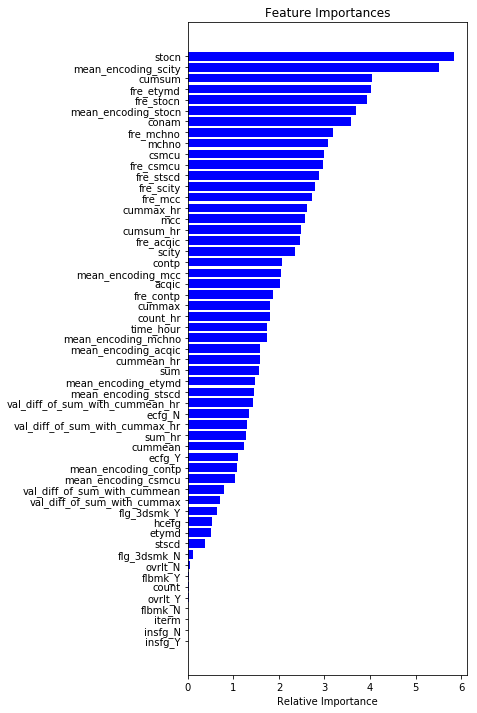

In [163]:
importances = clf.feature_importances_
indices = np.argsort(importances)
features = df_train_X.columns

plt.figure(figsize=(5,12)) # 調整長寬
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

In [72]:
clf = xgb.XGBClassifier(n_jobs=-1)
clf.fit(df_train_X, df_train_y)

/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [76]:
pred_pro = clf.predict_proba(df_test_mart)[:,1]

In [77]:
pred_pro

array([0.00602977, 0.00525954, 0.00496068, ..., 0.00038701, 0.00132022,
       0.000654  ], dtype=float32)

In [ ]:
pro = np.array([])
idx = np.array([])
for i in range(len(pred_pro)):
    pro = np.append(pro, pred_pro[i].reshape(-1))
    idx = np.append(idx, te_index[i])
idx = idx.astype(int)
oof = pd.DataFrame()
oof['pro'] = pro
oof.index = idx
oof = oof.sort_index()
oof['txkey'] = train['txkey'].values

In [ ]:
oof.head()

In [ ]:
# oof.to_csv('oof_date.csv',index=None)

In [ ]:
meta_feature = pd.DataFrame()
meta_feature['txkey'] = test['txkey']
meta_feature['feature'] = np.mean(meta_y,axis=1)

In [ ]:
meta_feature.head()

In [ ]:
# meta_feature.to_csv('meta_feature_date.csv',index=None)

# 7. submission

In [151]:
pd.Series(np.where(pred_pro > 0.35,1,0)).value_counts(normalize=True)

0    0.986658
1    0.013342
dtype: float64

In [152]:
## predict
predictions =  np.where(pred_pro > 0.35,1,0)

In [153]:
submission = pd.DataFrame({'txkey':df_test_id, 'fraud_ind': predictions})

In [154]:
submission.to_csv('submission_1021_catbo.csv',index=None)